# Графики для аналитической главы. Первая версия
## Графики используются для ICCT-2024
Данный блокнот пересчитывает параметры протокола RFID и значения BER во
входные данные для имитационных и аналитических моделей,
которые рассчитывают время, необходимое для чтения RFID метки.
Порядок работы с блокнотом:
1) Задать параметры протокола RFID
2) Выбрать номер сценария и задать дополнительные настройки
3) Вычислить входные параметры для моделей (массивы вероятностей и временных промежутков)
4) Запустить расчёт одной или нескольких имитационных моделей
5) Запустить расчёт одной или нескольких аналитических моделей
6) На основе полученных результатов построить графики

### 1й сценарий:

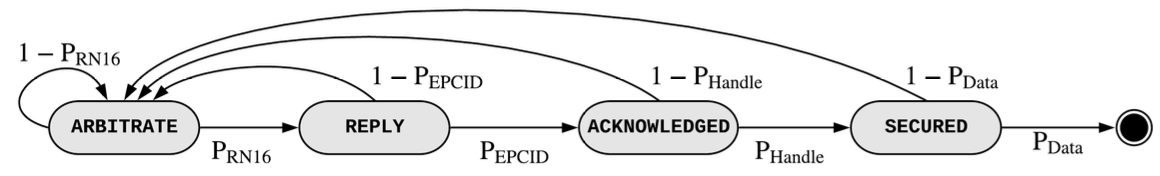

### 2й сценарий:

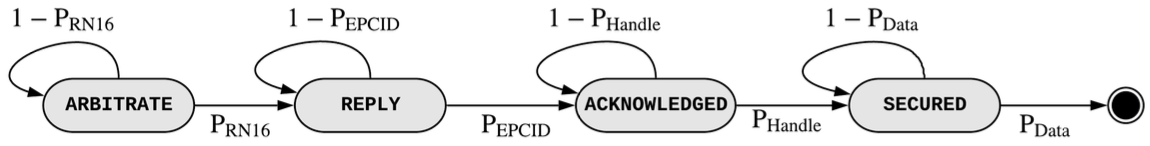

### 3й сценарий:

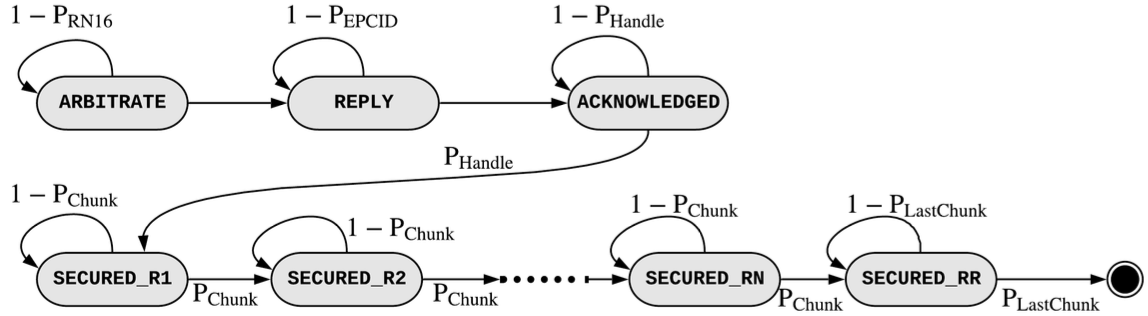

### Импорт необходимых модулей

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Аналитические и Монте-Карло модели
from pysim.models.monte_carlo.analitical_model import (
    convert_data_for_analitica, run_analitica
)
from pysim.models.monte_carlo.cli import run_multiple_simulation
from pysim.models.rfid.epcstd import(
    DivideRatio, TagEncoding
)

# Расчёт входных параметров для моделей
from utility.calculate_params import (
    build_messages_df, calculate_chunks,
    create_dicts, prepare_probs, prepare_times
)

# Форматирование и работа с графиками
from utility.graphs_style import (
    get_color, savefig,
    setup_matplotlib, set_axes_formatter
)

## Задать константы и параметры моделирования

### Параметры модели

In [2]:
# Количество моделируемых точек (= имитационок)
# Рекомендуемое количество от 15 до 30
POINTS_NUMBER: int = 20
BER: np.array = np.linspace(0, 0.01, num=POINTS_NUMBER)
# Количество повторов в одной симуляции (чем больше, тем выше точность)
# Рекомендуемое количество от 15_000 до 50_000
DEFAULT_MAX_TRANSMISSIONS: int = 20_000
delta: int = 1e-5 # с. Константа для рассчёта времени

### Изменяемые параметры
Внимание! Для 1 и 2го сценария количество 'чанков' должно равняться единице!
Для 3го сценария количество чанков должно быть строго меньше минимального значения количества слов!

In [3]:
########################################################
# ПАРАМЕТРЫ ПРОТОКОЛА RFID
# Для каждого параметра дана ссылка на стандарт
# ------------------------------------------------------
# Divide ratio (DR_8 или DR_643)
# Table 6.9: Tag-to-Interrogator link frequencies
DR = DivideRatio.DR_8
# ------------------------------------------------------
# # Тип кодирования ответов метки (FM0, M2, M4, M8)
# 6.3.1.3.2 Data encoding
M = TagEncoding.FM0
# ------------------------------------------------------
# Длительность Tari (6.25, 12.5, 18.75, 25) мкс
# 6.3.1.2.2 Modulation
TARI_US = 6.25
# ------------------------------------------------------
# Длительность преамбулы метки
# Длинная (True) или короткая (False)
# 6.3.1.3.2 Data encoding
TRExt = False
########################################################
# ВЫБОР СЦЕНАРИЕВ
# ------------------------------------------------------
# Номер сценария (1, 2, 3)
scenario: int = 1
# ------------------------------------------------------
# Количество передаваемых слов в состоянии Read
# Для каждого элемента кортежа запускается сет
# аналитических и Монте-Карло моделей.
# Соответственно, каждое значение отвечает за
# одну результирующую кривую. Длина кортежа =
# = количеству кривых на графике
# words_numbers: tuple = (4, 8, 16, 32)
words_numbers: tuple[int, int, int, int] = (2, 4, 6, 8)
# ------------------------------------------------------
# ДЛЯ 1 И 2 СЦЕНАРИЕВ ДОЛЖНО РАВНЯТЬСЯ 1
# Количество чанков, на которые разбивается
# передаваемая информация в состоянии Read для
# 3 сценария
chunks_number: int = 1 if scenario in (1, 2) else 4
########################################################

## Инициализация команд и ответов

In [4]:
chunks_info_list = []
# Для каждой кривой создаём кортеж: (Слов в одном чанке, Слов в последнем чанке).
# Все кортежи добавляем в один лист.
for words_number in words_numbers:
    chunks_info_list.append(calculate_chunks(words_number, chunks_number))

params_list = []
# Индекс переменной с количеством слов в одном чанке
index_words_in_chunk = 0
# Индекс переменной с количеством слов в последнем чанке
index_words_in_last_chunk = 1
# Для каждой кривой генерируем набор RFID команд и ответов
for i in range(len(chunks_info_list)):
    params_list.append(
        build_messages_df(
            TARI_US, M, DR, TRExt, chunks_number,
            chunks_info_list[i][index_words_in_chunk],
            chunks_info_list[i][index_words_in_last_chunk]
        )
    )

### Расчёт вероятностей (BER - вход в модель)

Вероятность успешного перехода из одного состояния в другое определяется
исключительно ответами метки (так как во всём проекте сделано допущение, что
если метка оказалась в зоне чтения, то она гарантировано включается, корректно
получает команду считывателя и принимает участие в текущем раунде). Вероятность
перехода в следующее состояние равна вероятности успешного получения считывателем
ответа метки.
Вероятность определяется выражением:
$$ P_{msg} = (1 - BER)^{|msg|} $$
где msg - передаваемое сообщение, BER - вероятность битовой ошибки, |msg| - длина сообщения в битах

In [5]:
probs_list = []
for i in range(len(words_numbers)):
    probs_list.append(prepare_probs(params_list[i], chunks_number, BER, POINTS_NUMBER))

### Расчёт времён (время команд - вход в модель)

Время перехода из одного состояния в другое вычисляется по формулам:
$$T_{Arbitrate} = T_{Query} + T_1 + T_{RN16} + T_2 + 2\delta$$ 
$$T_{Reply} = T_{Ack} + T_1 + T_{EPC} + T_2 + 2\delta$$
$$T_{Acknowledged} = T_{Req_RN} + T_1 + T_{Handle} + T_2 + 2\delta$$
$$T_{Secured} = T_{Read} + T_1 + T_{Data} + T_2 + 2\delta$$
$$T_{Secured.Ri} = T_{Read} + T_1 + T_{Chunk.i} + T_2 + 2\delta$$
$$T_{Secured.LC} = T_{Read} + T_1 + T_{Last.Chunk} + T_2 + 2\delta$$
где $T_{msg.name}$ - длительность команды считывателя или ответа метки, 
$T_{Secured.Ri}$ - длительность для i-го 'чанка', 
$T_{Secured.ДС}$ - длительность последнего 'чанка', 
$T_1$ и $T_2$ - параметры, определяемые протоколом RFID (в блокноте рассчитываются с помощью функций), 
$\delta$ - время распространения сигнала (в блокноте определяется как взятая наобум константа)

In [6]:
t_list = []
for i in range(len(words_numbers)):
    t_list.append(prepare_times(params_list[i], probs_list[i], chunks_number))

### Подготовка входных данных для имитационных моделей

In [7]:
dicts_list = []
for i in range(len(words_numbers)):
    dicts_list.append(create_dicts(probs_list[i], t_list[i], chunks_number, scenario, DEFAULT_MAX_TRANSMISSIONS))

### Запуск имитационных моделей

In [8]:
results_list = []
for i in range(len(words_numbers)):
    # Результат работы одного пакета имитационок (одна кривая)
    one_packet = run_multiple_simulation(dicts_list[i])
    res = []
    for i in one_packet:
        res.append(i.sim_time/DEFAULT_MAX_TRANSMISSIONS*1_000) # миллисекунды
    results_list.append(res)

Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена
Симуляция завершена


### Запуск аналитических моделей

In [9]:
phases_list = []
for i in range(len(words_numbers)):
    phases_list.append(convert_data_for_analitica(probs_list[i], t_list[i]))

analit_res_list = []
for i in range(len(words_numbers)):
    analit_res_list.append(run_analitica(scenario, phases_list[i], chunks_number))

### Расчёт погрешности

In [10]:
error_values = [abs((j-k)/j*100) for k, j in zip(analit_res_list[3], results_list[3])]
sum(error_values)/len(error_values)

np.float64(0.12637954403434612)

### Построение графиков

In [11]:
setup_matplotlib()

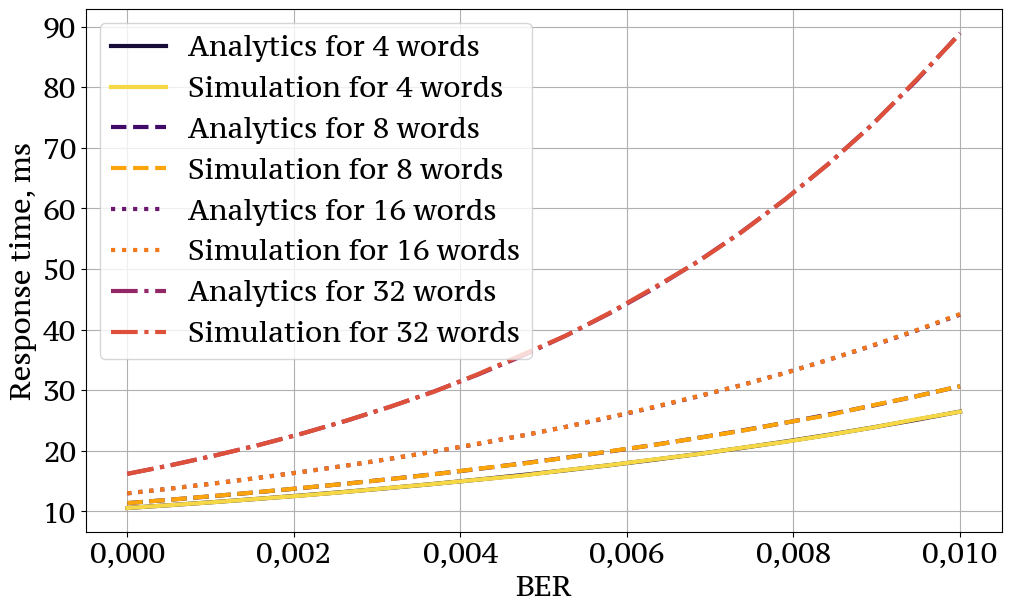

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

ax.set_xlabel('BER', fontsize=20) 
ax.set_ylabel('Response time, ms', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# ax.set_title(f'Reading time for {scenario}st scenario')

# 1я пара
# --------------------------------------
ax.plot(
    BER, analit_res_list[0],
    linewidth=3, linestyle='-',
    label=f'Analytics for {words_numbers[0]} words',
    color=get_color(0.1)
)
ax.plot(
    BER, results_list[0],
    linewidth=3, linestyle='-',
    label=f'Simulation for {words_numbers[0]} words',
    color=get_color(0.9)
)
# 2я пара
# --------------------------------------
ax.plot(
    BER, analit_res_list[1],
    linewidth=3, linestyle='--',
    label=f'Analytics for {words_numbers[1]} words',
    color=get_color(0.2)
)

ax.plot(
    BER, results_list[1],
    linewidth=3, linestyle='--',
    label=f'Simulation for {words_numbers[1]} words',
    color=get_color(0.8)
)
# 3я пара
# --------------------------------------
ax.plot(
    BER, analit_res_list[2],
    linewidth=3, linestyle='dotted',
    label=f'Analytics for {words_numbers[2]} words',
    color=get_color(0.3)
)
ax.plot(
    BER, results_list[2],
    linewidth=3, linestyle='dotted',
    label=f'Simulation for {words_numbers[2]} words',
    color=get_color(0.7)
)
# 4я пара
# --------------------------------------
ax.plot(
    BER, analit_res_list[3],
    linewidth=3, linestyle='dashdot',
    label=f'Analytics for {words_numbers[3]} words',
    color=get_color(0.4)
)
ax.plot(
    BER, results_list[3],
    linewidth=3, linestyle='dashdot',
    label=f'Simulation for {words_numbers[3]} words',
    color=get_color(0.6)
)
# --------------------------------------
plt.legend(prop={"size":20})
plt.grid()
plt.savefig(f'img/{scenario}_scenario_large')